In [100]:
from functions import *

In [101]:
import matplotlib.pyplot as plt
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import glob
import time
from datetime import datetime
from collections import Counter
from PIL import Image

# Visualize one experiment

In [102]:
model='baseline_CNN'
exp = 1
spl = 3

#### Experiment details

In [156]:
df1=pd.read_excel(f'../official_results/{model}_results.xlsx')
df2=pd.read_excel(f'../official_results/old/{model}_results.xlsx')
df = pd.concat([df1, df2], ignore_index = True)
df

,Experiment,RMSE,Variables,Input,Split,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution
0,1,5.683873,lst,74 cells,stratified,3,Adam,1487,32,57 of 300,2024-11-20,10:35:18,259.58,Physics-guided,8
1,2,5.095058,lst,74 cells,stratified,3,Adam,1487,32,54 of 300,2024-11-20,10:39:12,232.63,RMSE,8
2,3,5.064375,lst,74 cells,stratified,3,Adam,1487,64,102 of 300,2024-11-20,10:49:56,292.51,Physics-guided,8
3,4,4.963711,lst,74 cells,stratified,3,Adam,1487,64,119 of 300,2024-11-20,10:55:22,323.51,RMSE,8
4,3,5.005169,lst,74 cells,stratified,3,Adam,1487,128,74 of 300,2024-11-20,10:57:50,146.31,Physics-guided,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,6,5.205161,lst,74 cells,stratified,2,Adam,1487,128,123 of 300,2024-11-19,15:47:30,265.10,Physics-guided,64
66,6,4.778100,lst,74 cells,stratified,3,Adam,1487,64,108 of 300,2024-11-19,15:48:31,301.57,RMSE,64
67,7,5.102246,lst,74 cells,stratified,2,Adam,1487,128,138 of 300,2024-11-19,15:52:23,290.87,RMSE,64
68,6,4.888248,lst,74 cells,stratified,3,Adam,1487,128,149 of 300,2024-11-19,15:53:35,301.87,Physics-guided,64


#### Learning curve

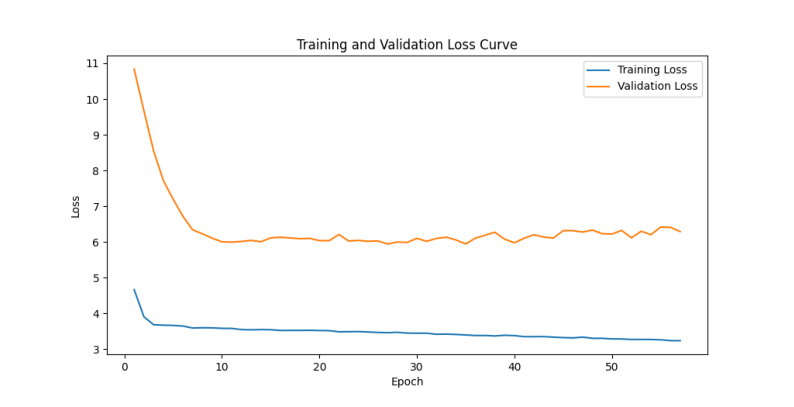

In [104]:
image_path = f'../official_results/learning_curves/{model}_exp_{exp}_split_{spl}.png'
image = Image.open(image_path)
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()


#### Error log

In [105]:
errors_df = pd.read_csv(f'../official_results/error_logs/{model}_exp_{exp}_split_{spl}.csv')

In [106]:
errors_df_filt = errors_df[errors_df['epoch'] <= 100]

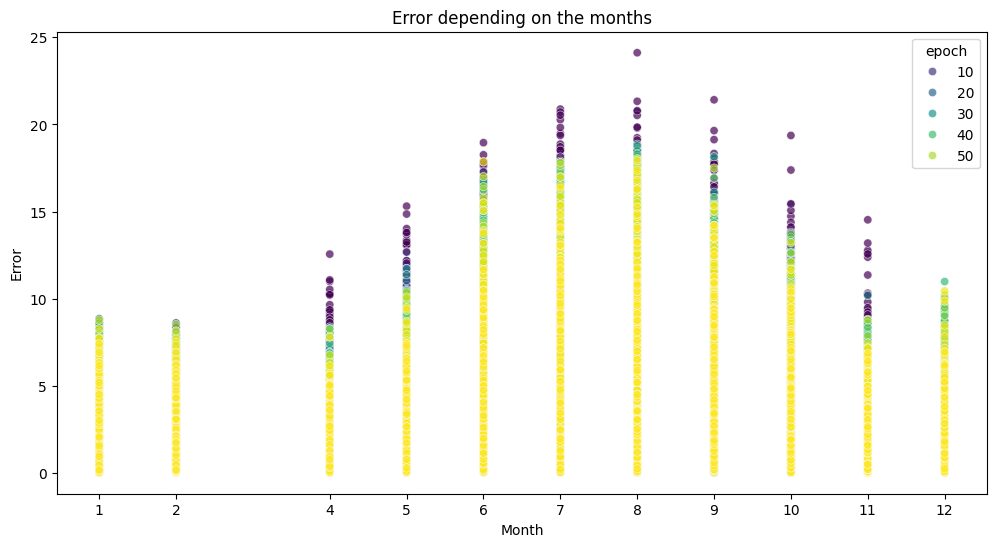

In [107]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=errors_df_filt, x="month", y="error", hue="epoch", palette="viridis", alpha=0.7)
plt.xticks(ticks=sorted(errors_df_filt["month"].unique()))
plt.title("Error depending on the months")
plt.xlabel("Month")
plt.ylabel('Error')
plt.show()

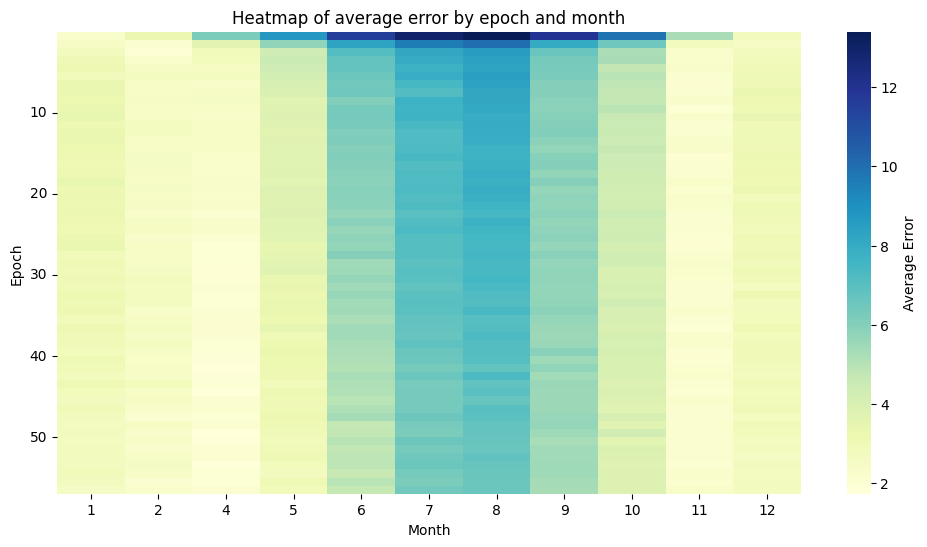

In [108]:
epochs = len(errors_df_filt.epoch.unique())
pivot_table = errors_df_filt.pivot_table(values="error", index="epoch", columns="month", aggfunc="mean")
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap="YlGnBu", cbar_kws={'label': 'Average Error'})
if epochs == 10:
    ticks = range(epochs + 1)
    labelss = [str(i) for i in range(epochs + 1)]
else:
    ticks = [i for i in range(10, epochs + 1, 10)]
    labelss = [str(i) for i in range(10, epochs + 1, 10)]
plt.yticks(ticks=ticks,labels=labelss)
plt.title("Heatmap of average error by epoch and month")
plt.xlabel("Month")
plt.ylabel("Epoch")
plt.show()

# Training parameters experimentation

### Compare RMSE for all baseline experiments

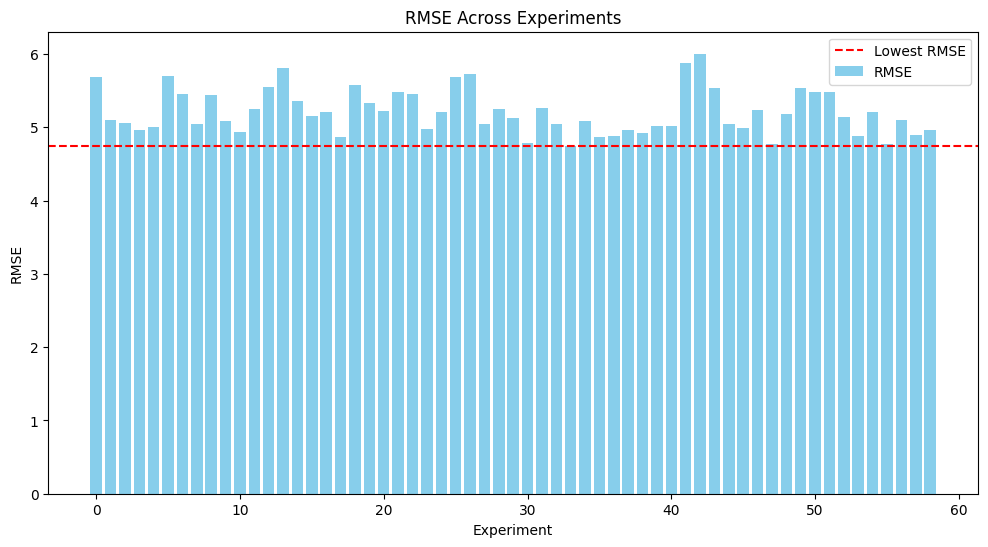

In [109]:
plt.figure(figsize=(12, 6))
plt.bar(df.index, df['RMSE'], color='skyblue', label="RMSE")
plt.axhline(y=df['RMSE'].min(), color='red', linestyle='--', label="Lowest RMSE")
plt.xlabel('Experiment')
plt.ylabel('RMSE')
plt.title('RMSE Across Experiments')
plt.legend()
plt.show()

## Image resolution and batch size analysis

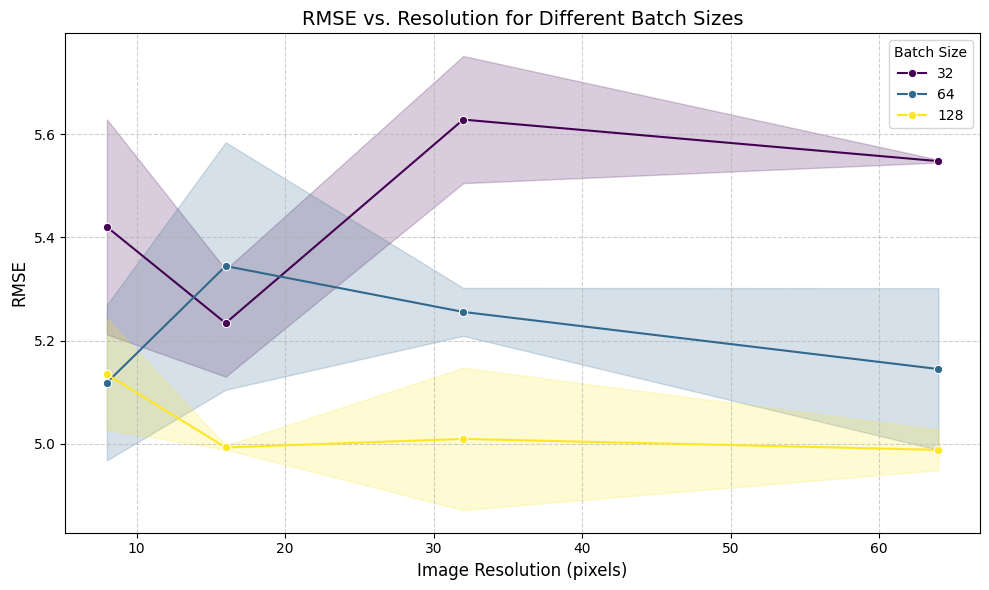

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico de líneas para cada batch size
plt.figure(figsize=(10, 6))
sns.lineplot(data=mean_rmse, x="Resolution", y="RMSE", hue="Batch size", marker="o", palette="viridis")
plt.title("RMSE vs. Resolution for Different Batch Sizes", fontsize=14)
plt.xlabel("Image Resolution (pixels)", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.legend(title="Batch Size", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


### Best combination (splits mean)

In [112]:
mean_rmse = df.groupby(["Resolution", "Batch size", "Loss"])["RMSE"].mean().reset_index()

# Identificar la combinación con el menor RMSE
best_combination = mean_rmse.loc[mean_rmse["RMSE"].idxmin()]

print("Best Combination:")
print(best_combination)

Best Combination:
Resolution          32
Batch size         128
Loss              RMSE
RMSE          4.921343
Name: 17, dtype: object


In [113]:
# Ordenar las combinaciones por RMSE promedio
mean_rmse_sorted = mean_rmse.sort_values("RMSE")

print("Top Combinations by Average RMSE:")
print(mean_rmse_sorted.head(10))  # Ver las 10 mejores combinaciones


Top Combinations by Average RMSE:
    Resolution  Batch size            Loss      RMSE
17          32         128            RMSE  4.921343
23          64         128            RMSE  4.948712
3            8          64            RMSE  4.967539
21          64          64            RMSE  4.987893
10          16         128  Physics-guided  4.988699
11          16         128            RMSE  4.996619
4            8         128  Physics-guided  5.027155
22          64         128  Physics-guided  5.027264
9           16          64            RMSE  5.104628
16          32         128  Physics-guided  5.105717


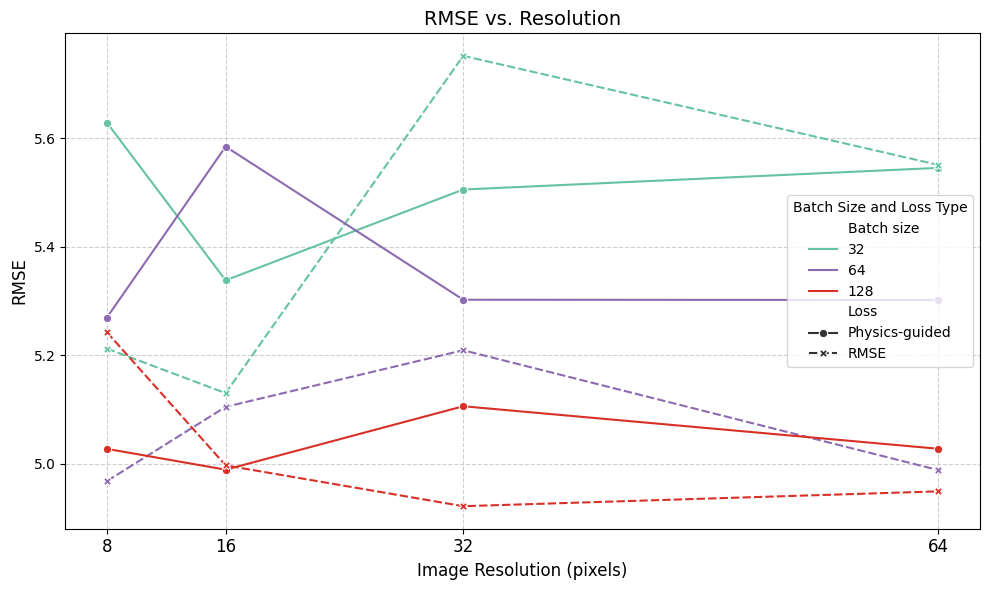

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

custom_palette = {
    32: "#66c2a4",  # Verde
    64: "#8c6bb1",  # Lila
    128: "#d73027"  # Rojo
}
# Crear un gráfico para los datos filtrados
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=mean_rmse,
    x="Resolution",
    y="RMSE",
    hue="Batch size",
    style="Loss",  # Diferenciar por tipo de Loss
    markers=True,
    palette=custom_palette  # Paleta de colores
)

resolutions_used = sorted(mean_rmse["Resolution"].unique())  # Obtener resoluciones únicas para este Split_id
plt.xticks(resolutions_used, labels=[str(res) for res in resolutions_used], fontsize=12)


# Configurar título y ejes
plt.title(f"RMSE vs. Resolution", fontsize=14)
plt.xlabel("Image Resolution (pixels)", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.legend(title="Batch Size and Loss Type", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


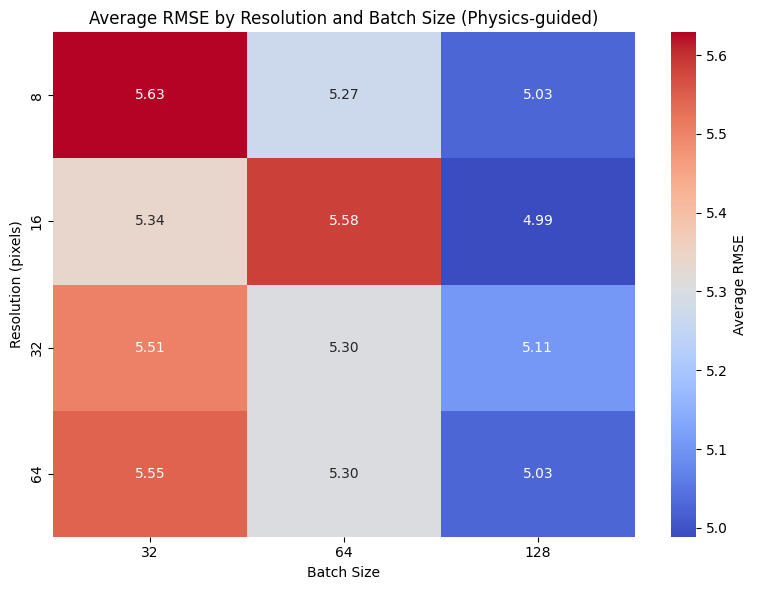

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar por tipo de Loss (por ejemplo, "Physics-guided")
physics_mean_rmse = mean_rmse[mean_rmse["Loss"] == "Physics-guided"].pivot(
    index="Resolution", columns="Batch size", values="RMSE"
)

plt.figure(figsize=(8, 6))
sns.heatmap(physics_mean_rmse, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Average RMSE'})
plt.title("Average RMSE by Resolution and Batch Size (Physics-guided)")
plt.xlabel("Batch Size")
plt.ylabel("Resolution (pixels)")
plt.tight_layout()
plt.show()


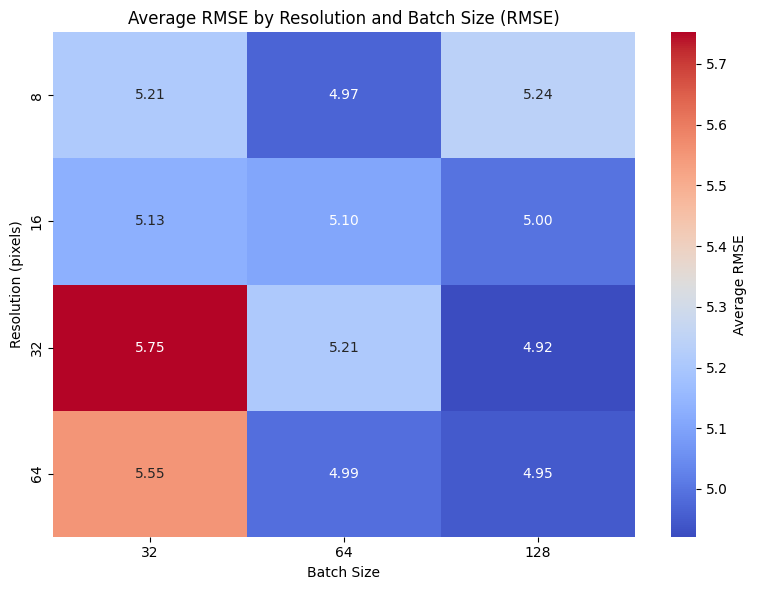

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar por tipo de Loss (por ejemplo, "Physics-guided")
physics_mean_rmse = mean_rmse[mean_rmse["Loss"] == "RMSE"].pivot(
    index="Resolution", columns="Batch size", values="RMSE"
)

plt.figure(figsize=(8, 6))
sns.heatmap(physics_mean_rmse, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Average RMSE'})
plt.title("Average RMSE by Resolution and Batch Size (RMSE)")
plt.xlabel("Batch Size")
plt.ylabel("Resolution (pixels)")
plt.tight_layout()
plt.show()


## Optimizer analysis

In [157]:
best_results = df[(df.Resolution==32)&(df['Batch size']==128)&(df['Loss']=='RMSE')]
best_results

,Experiment,RMSE,Variables,Input,Split,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution
17,14,4.870761,lst,74 cells,stratified,3,Adam,1487,128,124 of 300,2024-11-20,12:41:19,243.46,RMSE,32
35,20,4.871874,lst,74 cells,stratified,1,Adam,1487,128,193 of 300,2024-11-20,13:59:44,378.09,RMSE,32
36,37,4.885543,lst,74 cells,stratified,1,SGD,1487,128,111 of 300,2024-11-20,14:24:39,181.10,RMSE,32
37,37,4.962777,lst,74 cells,stratified,2,SGD,1487,128,137 of 300,2024-11-20,14:26:24,218.26,RMSE,32
38,39,4.923957,lst,74 cells,stratified,3,SGD,1487,128,109 of 300,2024-11-20,14:37:29,179.43,RMSE,32
39,40,5.013146,lst,74 cells,stratified,2,Adam,1487,128,149 of 300,2024-11-20,14:49:25,300.96,RMSE,32
42,43,4.972216,lst,74 cells,stratified,1,"SGD w/ dynamic-lr, momentum 0.9 & nesterov",1487,128,104 of 300,2024-11-20,15:22:32,178.70,RMSE,32
43,44,5.057354,"lst, ndvi",74 cells,stratified,1,Adam,1487,128,140 of 300,2024-11-20,15:37:42,288.48,RMSE,32
44,44,5.011759,"lst, ndvi",74 cells,stratified,2,Adam,1487,128,118 of 300,2024-11-20,15:38:21,246.90,RMSE,32
45,44,4.853449,"lst, ndvi",74 cells,stratified,3,Adam,1487,128,113 of 300,2024-11-20,15:39:22,230.11,RMSE,32


In [145]:
rmse_mean = best_results.groupby('Optimizer')['RMSE'].mean().reset_index()

rmse_mean = rmse_mean.sort_values(by='RMSE')

print(rmse_mean)

                                    Optimizer      RMSE
1                                         SGD  4.924092
2  SGD w/ dynamic-lr, momentum 0.9 & nesterov  4.972216
0                                        Adam  5.022102


# Variables experimentation

In [158]:
df_vars = best_results[best_results.Optimizer=='Adam']
df_vars

,Experiment,RMSE,Variables,Input,Split,Split_id,Optimizer,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution
17,14,4.870761,lst,74 cells,stratified,3,Adam,1487,128,124 of 300,2024-11-20,12:41:19,243.46,RMSE,32
35,20,4.871874,lst,74 cells,stratified,1,Adam,1487,128,193 of 300,2024-11-20,13:59:44,378.09,RMSE,32
39,40,5.013146,lst,74 cells,stratified,2,Adam,1487,128,149 of 300,2024-11-20,14:49:25,300.96,RMSE,32
43,44,5.057354,"lst, ndvi",74 cells,stratified,1,Adam,1487,128,140 of 300,2024-11-20,15:37:42,288.48,RMSE,32
44,44,5.011759,"lst, ndvi",74 cells,stratified,2,Adam,1487,128,118 of 300,2024-11-20,15:38:21,246.90,RMSE,32
45,44,4.853449,"lst, ndvi",74 cells,stratified,3,Adam,1487,128,113 of 300,2024-11-20,15:39:22,230.11,RMSE,32
46,47,5.058354,"lst, ndvi, slope, direction, altitude",74 cells,stratified,1,Adam,1487,128,139 of 300,2024-11-20,15:55:36,276.64,RMSE,32
47,47,5.534033,"lst, ndvi, slope, direction, altitude",74 cells,stratified,2,Adam,1487,128,167 of 300,2024-11-20,16:00:56,335.89,RMSE,32
48,48,4.928192,"lst, ndvi, altitude, direction, slope",74 cells,stratified,3,Adam,1487,128,137 of 300,2024-11-20,16:01:00,284.80,RMSE,32
49,50,4.848934,"lst, ndvi, slope, direction, altitude, month, ...",74 cells,stratified,1,Adam,1487,128,76 of 300,2024-11-20,16:12:50,174.65,RMSE,32


/tmp/ipykernel_674467/2286790308.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vars['Normalized Variables'] = df_vars['Variables'].apply(


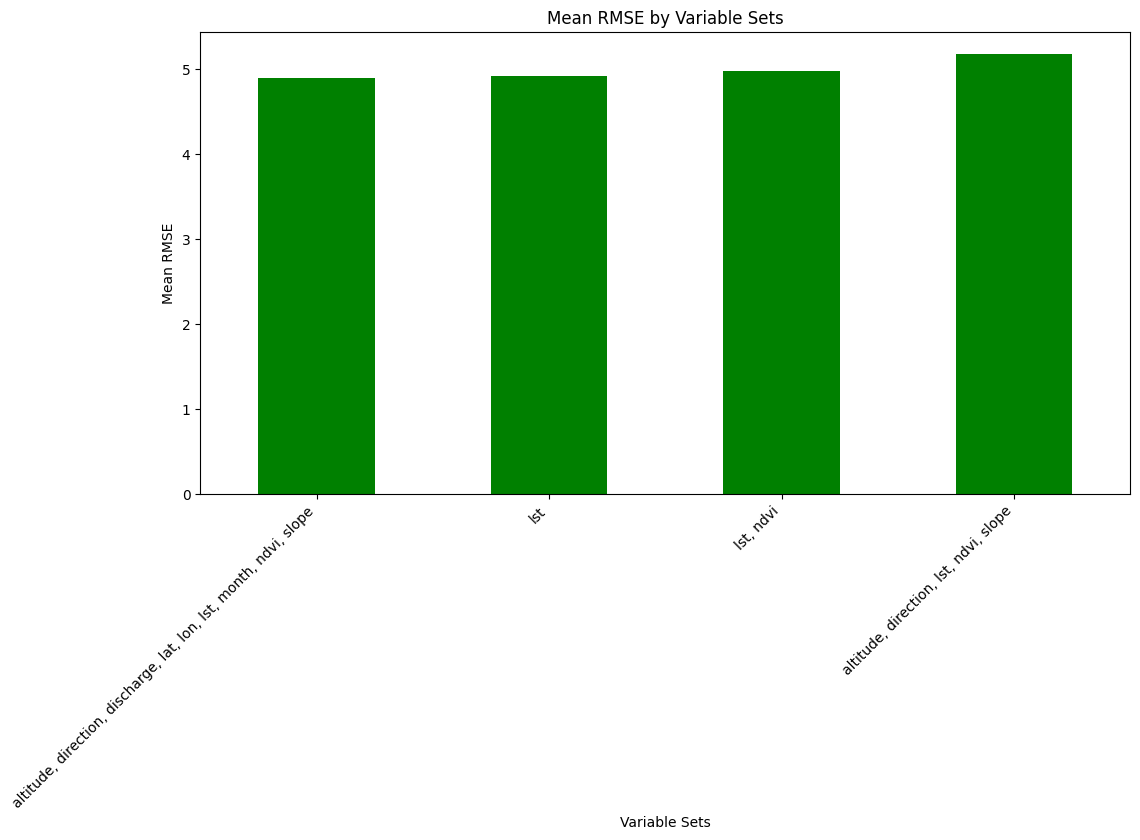

In [159]:
# Group by Variables and calculate mean RMSE
df_vars['Normalized Variables'] = df_vars['Variables'].apply(
    lambda x: ', '.join(sorted(x.split(', ')))
)
# Agrupar por las variables normalizadas y calcular la media del RMSE
variables_rmse = df_vars.groupby('Normalized Variables')['RMSE'].mean().sort_values()

# Plot mean RMSE for each variable set
plt.figure(figsize=(12, 6))
variables_rmse.plot(kind='bar', color='green')
plt.xlabel('Variable Sets')
plt.ylabel('Mean RMSE')
plt.title('Mean RMSE by Variable Sets')
plt.xticks(rotation=45, ha='right')
plt.show()
